# LangGraph Tutorial with Llama.cpp -> Full Open Source

Following the tutorial: https://langchain-ai.github.io/langgraph/tutorials/introduction/#part-1-build-a-basic-chatbot

In [ ]:
#%%capture --no-stderr
#%pip install -U --quiet langchain-community tiktoken langchain-openai langchainhub chromadb langchain langgraph langchain-text-splitters

In [ ]:
#!CMAKE_ARGS="-DLLAMA_METAL=on" FORCE_CMAKE=1 pip install --upgrade --force-reinstall llama-cpp-python --no-cache-dir

In [11]:
from langchain_community.llms import LlamaCpp
from langchain_core.callbacks import CallbackManager, StreamingStdOutCallbackHandler
from langchain_core.prompts import PromptTemplate

In [12]:
template = """Question: {question}

Answer: Let's work this out in a step by step way to be sure we have the right answer."""

prompt = PromptTemplate.from_template(template)

# Callbacks support token-wise streaming
callback_manager = CallbackManager([StreamingStdOutCallbackHandler()])

In [13]:
model_path = "/Users/busraoguzoglu/Desktop/Okul/586Project/llm_model/llama-2-13b-chat.Q4_0.gguf"
n_gpu_layers = -1  # The number of layers to put on the GPU. The rest will be on the CPU. If you don't know how many layers there are, you can use -1 to move all to GPU.
n_batch = 512  # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.

llm = LlamaCpp(
    model_path = model_path,
    temperature=0.75,
    max_tokens=2000,
    top_p=1,
    n_gpu_layers=n_gpu_layers,
    n_batch=n_batch,
    f16_kv=True,  # For M2: MUST set to True, otherwise you will run into problem after a couple of calls
    callback_manager=callback_manager,
    verbose=True,  # Verbose is required to pass to the callback manager
)

llama_load_model_from_file: using device Metal (Apple M2 Pro) - 14418 MiB free
llama_model_loader: loaded meta data with 19 key-value pairs and 363 tensors from /Users/busraoguzoglu/Desktop/Okul/586Project/llm_model/llama-2-13b-chat.Q4_0.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 5120
llama_model_loader: - kv   4:                          llama.block_count u32              = 40
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 13824
llama_model_loader: - kv   6:                 llama.rop

In [14]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

Chatbot node function takes the current State as input and returns a dictionary containing an updated messages list under the key "messages". This is the basic pattern for all LangGraph node functions.

The add_messages function in our State will append the llm's response messages to whatever messages are already in the state.

In [15]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

Add states

In [16]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

Visualize states

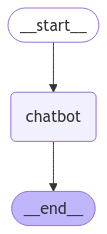

In [17]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Run the chatbot

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        print("User input case")
        user_input = input("User: ")
        print("User input:", user_input)
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    
    except:
        print("no input")